# Power Spectrum Score

> In the ocean community, we often operator in the Fourier domain. 
This is useful for assessing the quality of our models and it can also be useful for learning.
In this notebook, we showcase how oceanbench has two fundamental transformations that are useful for both cases: isotropic and spacetime Fourier transformations.

In [1]:
import autoroot
import typing as tp
from dataclasses import dataclass
import numpy as np
import pandas as pd
import xarray as xr
import einops
from metpy.units import units
import pint_xarray
import xarray_dataclasses as xrdataclass
from oceanbench._src.datasets.base import XRDABatcher
from oceanbench._src.geoprocessing.spatial import transform_360_to_180
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


In [2]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet

2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [3]:
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet/2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc"
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/MIOST/2020a_SSH_mapping_NATL60_MIOST_swot_en_j1_tpn_g2.nc"
# file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS/ssh_DUACS_swot_4nadir.nc"
file = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/BFNQG/2020a_SSH_mapping_NATL60_BFN_Steady_State_QG1L_swot_en_j1_tpn_g2.nc"
file_ref = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
!ls $file

/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/BFNQG/2020a_SSH_mapping_NATL60_BFN_Steady_State_QG1L_swot_en_j1_tpn_g2.nc


In [4]:
# # Domain for analysis: Gulfstream
# time_min = numpy.datetime64('2012-10-22')                # domain min time
# time_max = numpy.datetime64('2012-12-03')                # domain max time
# lon_min = -64.975                                        # domain min lon
# lon_max = -55.007                                        # domain max lon
# lat_min = 33.025                                         # domain min lat
# lat_max = 42.9917                                        # domain max lat

In [5]:
def open_ssh_results(file, variable="ssh_mod"):
    
    da = xr.open_dataset(file, decode_times=True)
    
    da = da.sortby("time")
    
    da = da.rename({variable: "ssh"})
    
    da = da.sel(
        time=slice("2012-10-22", "2012-12-03"),
        lon=slice(-64.975, -55.007),
        lat=slice(33.025, 42.9917),
        drop=True
    )
    
    da = da.resample(time="1D").mean()
    
    return da

def open_ssh_reference(file, variable="gssh"):
    da = xr.open_dataset(file, decode_times=False)
    da["time"] = pd.to_datetime(da.time)
    da = da.sortby("time")
    da = da.sel(
        time=slice("2012-10-22", "2012-12-03"),
        lon=slice(-64.975, -55.007),
        lat=slice(33.025, 42.9917),
        drop=True
    )
    # da = da.rename({variable: "ssh"})
    return da

In [6]:
def correct_names(da):
    
    da["ssh"].attrs["long_name"] = "Sea Surface Height"
    da["ssh"].attrs["standard_name"] = "sea_surface_height"

    da["lat"] = da.lat.pint.quantify("degrees_north")
    da["lat"].attrs["long_name"] = "Latitude"
    da["lat"].attrs["standard_name"] = "latitude"

    da["lon"].attrs["long_name"] = "Longitude"
    da["lon"].attrs["standard_name"] = "longitude"

    da["lon"] = transform_360_to_180(da.lon)
    

    
    return da



In [7]:
da_ref = open_ssh_reference(file_ref)
da = open_ssh_results(file, "gssh")

da_ref = correct_names(da_ref)
da = correct_names(da)


## Regridding

In [8]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid

In [9]:
da = grid_to_regular_grid(
    src_grid_ds=da.pint.dequantify(),
    tgt_grid_ds=da_ref.pint.dequantify(), keep_attrs=True
)
da

<xarray.Dataset>
Dimensions:  (time: 42, lat: 199, lon: 199)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
  * lon      (lon) float64 -64.95 -64.9 -64.85 -64.8 ... -55.15 -55.1 -55.05
  * lat      (lat) float64 33.05 33.1 33.15 33.2 33.25 ... 42.8 42.85 42.9 42.95
Data variables:
    ssh      (time, lat, lon) float64 nan 0.649 0.6539 ... -0.1912 -0.195
Attributes:
    regrid_method:  bilinear

### Interpolate NANs

In [10]:
from oceanbench._src.geoprocessing.interpolate import fillnans

In [11]:
da = fillnans(da, dims=["lat", "lon"], method="slinear", fill_value="extrapolate")
da_ref = fillnans(da_ref, dims=["lat", "lon"], method="slinear", fill_value="extrapolate")

### Units

In [12]:
def add_units(da):
    da = da.pint.quantify(
        {"ssh": "meter", 
         "lon": "degrees_east", 
         "lat": "degrees_north",
         "time": "nanoseconds"
        }
    )
    return da

In [13]:
da = add_units(da)
da_ref = add_units(da_ref)

## Rescaling

In a previous notebook, we showed how we can do lat/lon

#### Degrees to Meters

It is often more useful to have things in meters instead of degrees. The units are more meaningful and easier to interpret. So we can do a simple degree to meters transformation included in the library.

In [14]:
from oceanbench._src.geoprocessing.spatial import latlon_deg2m
from oceanbench._src.geoprocessing.temporal import time_rescale

In [15]:
t0 = "2012-10-22"
freq_dt = 1
freq_unit = "D"

# spatial rescale
da = latlon_deg2m(da, mean=True)
da_ref = latlon_deg2m(da_ref, mean=True)

# temporal rescale
da_ref = time_rescale(da_ref, freq_dt=freq_dt, freq_unit=freq_unit, t0=t0)
da = time_rescale(da, freq_dt=freq_dt, freq_unit=freq_unit, t0=t0)

## Spectral Domain

In [22]:
def rmse_da(da, da_ref, variable, dim):
    return ((da[variable] - da_ref[variable]) ** 2).mean(dim=dim) ** 0.5


def nrmse_da(da, da_ref, variable, dim):
    rmse = rmse_da(da=da, da_ref=da_ref, variable=variable, dim=dim)
    std = (da_ref[variable]**2).mean(dim=dim) ** 0.5 
    try:
        return 1.0 - (rmse / std)
    except:
        return 1.0 - (rmse / std)

In [29]:
print(rmse_da(da=da, da_ref=da_ref, variable="ssh", dim=["lat", "lon", "time"]).values)

0.03773501645053605


In [30]:
print(nrmse_da(da=da, da_ref=da_ref, variable="ssh", dim=["lat", "lon", "time"]).values)

0.9351010566285083


In [31]:
print(nrmse_da(da=da, da_ref=da_ref, variable="ssh", dim=["lat", "lon"]).std().values)

0.01463799633924518


Now, we can look at how we can represent the data within the Fourier Domain

### Isotropic Assumption

In [121]:
from oceanbench._src.metrics import power_spectrum as psdcalc
from oceanbench._src.preprocessing.mean import xr_cond_average

In [122]:
da_psd_ref = psdcalc.psd_isotropic(da_ref, "ssh", ["lon", "lat"])
da_psd_ref = xr_cond_average(da_psd_ref, dims=["time"], drop=True)

da_psd = psdcalc.psd_isotropic(da, "ssh", ["lon", "lat"])
da_psd = xr_cond_average(da_psd, dims=["time"], drop=True)

### Plots

In [63]:
class PlotPSDIsotropic:
        
    def init_fig(self, ax=None, figsize=None):
        if ax is None:
            figsize = (5,4) if figsize is None else figsize
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else:
            self.ax = ax
            self.fig = plt.gcf()
        
    def plot_wavenumber(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavenumber [cycles/{units}]"
        else:
            xlabel = f"Wavenumber"
        
        self.ax.plot(da.freq_r * freq_scale, da, **kwargs)

        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]"
        )

        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
        
    def plot_wavelength(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        self.ax.plot(1/(da.freq_r * freq_scale), da, **kwargs)
        
        self.ax.set(
            yscale="log", xscale="log",
            xlabel=xlabel,
            ylabel=f"PSD [{da.name}]"
        )

        self.ax.xaxis.set_major_formatter("{x:.0f}")
        self.ax.invert_xaxis()
        
        self.ax.legend()
        self.ax.grid(which="both", alpha=0.5)
                
    def plot_both(self, da, freq_scale=1.0, units=None, **kwargs):
        
        if units is not None:
            xlabel = f"Wavelength [{units}]"
        else:
            xlabel = f"Wavelength"
        
        self.plot_wavenumber(da=da, units=units, freq_scale=freq_scale, **kwargs)
        
        self.secax = self.ax.secondary_xaxis(
            "top", functions=(lambda x: 1 / (x + 1e-20), lambda x: 1 / (x + 1e-20))
        )
        self.secax.xaxis.set_major_formatter("{x:.0f}")
        self.secax.set(xlabel=xlabel)

#### Wavenumber + Wavelength

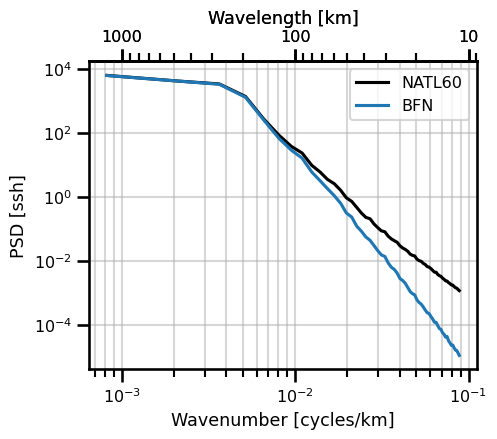

In [64]:
psd_iso_plot = PlotPSDIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_both(
    da_psd_ref.ssh,
    freq_scale=1e3, 
    units="km",
    label="NATL60",
    color="black",
)
psd_iso_plot.plot_both(
    da_psd.ssh,
    freq_scale=1e3, 
    units="km",
    label="BFN",
    color="tab:blue",
)
plt.show()

### PSD Score

$$
\text{Score}_{PSD} = 1 - \frac{PSD(u) - PSD(\hat{u})}{PSD(u)}
$$

In [123]:
from oceanbench._src.metrics import power_spectrum as psdcalc
from oceanbench._src.metrics.utils import find_intercept_1D, find_intercept_2D

In [124]:
da_psd_score_iso = psdcalc.psd_isotropic_score(
    da=da, da_ref=da_ref, 
    variable="ssh", 
    psd_dims=["lat", "lon"],
    avg_dims=["time"]
)

In [125]:
class PlotPSDScoreIsotropic(PlotPSDIsotropic):
    
    def _add_score(
        self,
        da,
        freq_scale=1.0, 
        units=None, 
        threshhold: float=0.5, 
        threshhold_color="k",
        name=""
):
        self.ax.set(ylabel="PSD Score", yscale="linear")
        self.ax.set_ylim((0,1.0))
        self.ax.set_xlim((
            np.ma.min(np.ma.masked_invalid(da.freq_r.values * freq_scale)),
            np.ma.max(np.ma.masked_invalid(da.freq_r.values * freq_scale)),
        ))
        
        resolved_scale = freq_scale / find_intercept_1D(
            x=da.values, y=1./da.freq_r.values, level=threshhold
        )        
        self.ax.vlines(
            x=resolved_scale, 
            ymin=0, ymax=threshhold, 
            color=threshhold_color,
            linewidth=2, linestyle="--",
        )
        self.ax.hlines(
            y=threshhold,
            xmin=np.ma.min(np.ma.masked_invalid(da.freq_r.values * freq_scale)),
            xmax=resolved_scale, color=threshhold_color,
            linewidth=2, linestyle="--"
        )        
        label = f"{name}: {1/resolved_scale:.0f} {units} "
        self.ax.scatter(
            resolved_scale, threshhold,
            color=threshhold_color, marker=".",
            linewidth=5, label=label,
            zorder=3
        )
        
        
    def plot_score(
        self, 
        da, 
        freq_scale=1.0, 
        units=None, 
        threshhold: float=0.5, 
        threshhold_color="k",
        name="",
        **kwargs
    ):
        
        self.plot_both(da=da, freq_scale=freq_scale, units=units, **kwargs)
        self._add_score(
            da=da, 
            freq_scale=freq_scale,
            units=units,
            threshhold=threshhold, 
            threshhold_color=threshhold_color,
            name=name
        )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


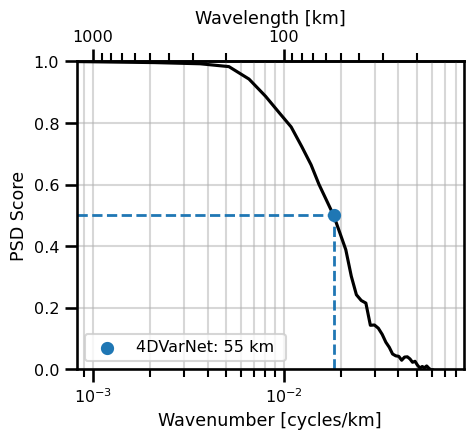

In [126]:
psd_iso_plot = PlotPSDScoreIsotropic()
psd_iso_plot.init_fig()
psd_iso_plot.plot_score(
    da_psd_score_iso.ssh,
    freq_scale=1e3, 
    units="km",
    name="4DVarNet",
    color="black",
    threshhold=0.50,
    threshhold_color="tab:blue"
    
)
plt.legend()

In [127]:
space_rs = find_intercept_1D(
    y=1./da_psd_score_iso.ssh.freq_r.values,
    x=da_psd_score_iso.ssh.values,
    level=0.5
)

In [128]:
print(f"(Isotropic) Spatial Resolved Scale: {space_rs/1e3:.2f} [km]")
print(f"(Isotropic) Spatial Resolved Scale: {space_rs/1e3/111:.2f} [degrees]")

(Isotropic) Spatial Resolved Scale: 54.64 [km]
(Isotropic) Spatial Resolved Scale: 0.49 [degrees]


### Spatial Temporal

#### Time vs Longitude

In [129]:
# frequency dims
da_ref_psd_st = psdcalc.psd_spacetime(da_ref, "ssh", ["time", "lon"])
da_psd_st = psdcalc.psd_spacetime(da, "ssh", ["time", "lon"])


# average other dims
da_ref_psd_st = xr_cond_average(da_ref_psd_st, dims=["lat"], drop=True)
da_psd_st = xr_cond_average(da_psd_st, dims=["lat"], drop=True)

In [130]:
da_psd_st

<xarray.Dataset>
Dimensions:    (freq_time: 20, freq_lon: 99)
Coordinates:
  * freq_time  (freq_time) float64 0.02381 0.04762 0.07143 ... 0.4524 0.4762
  * freq_lon   (freq_lon) float64 9.038e-07 1.808e-06 ... 8.858e-05 8.948e-05
Data variables:
    ssh        (freq_time, freq_lon) float64 4.288e+04 6.396e+04 ... 0.001237

In [131]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker


class PlotPSDSpaceTime:
    def init_fig(self, ax=None, figsize=None):
        if ax is None:
            figsize = (5,4) if figsize is None else figsize
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else:
            self.ax = ax
            self.fig = plt.gcf()
        
    def plot_wavenumber(
        self, 
        da, 
        space_scale: float=1.0,
        space_units: str=None,
        time_units: str=None,
        psd_units: float=None,
        **kwargs):
        
        if space_units is not None:
            xlabel = f"Wavenumber [cycles/{space_units}]"
        else:
            xlabel = f"Wavenumber"
        if time_units is not None:
            ylabel = f"Frequency [cycles/{time_units}]"
        else:
            ylabel = f"Frequency"

        if psd_units is None:
            cbar_label = "PSD"
        else:
            cbar_label = f"PSD [{psd_units}]"
        
        locator = ticker.LogLocator()
        norm = colors.LogNorm()
        
        pts = self.ax.contourf(
            1/(da.freq_lon*space_scale),
            1/da.freq_time, 
            da.transpose("freq_time", "freq_lon"), 
            norm=norm, 
            locator=locator, 
            cmap=kwargs.pop("cmap", "RdYlGn"), 
            extend=kwargs.pop("extend", "both"),
            **kwargs
        )

        self.ax.set(
            yscale="log",
            xscale="log",
            xlabel=xlabel,
            ylabel=ylabel,
        )
        # colorbar
        fmt = ticker.LogFormatterMathtext(base=10)
        cbar = plt.colorbar(
            pts,
            ax=self.ax,
            pad=0.02,
            format=fmt,
        )
        cbar.ax.set_ylabel(cbar_label)
        self.ax.invert_xaxis()
        self.ax.invert_yaxis()
        self.ax.grid(which="both", linestyle="--", linewidth=1, color="black", alpha=0.2)


    def plot_wavelength(        
        self, 
        da, 
        space_scale: float=1.0,
        space_units: str=None,
        time_units: str=None,
        psd_units: float=None,
        **kwargs
    ):
    
        if space_units is not None:
            xlabel = f"Wavelength [{space_units}]"
        else:
            xlabel = f"Wavelength"
            
        if time_units is not None:
            ylabel = f"Period [{time_units}]"
        else:
            ylabel = f"Period"
            
        if psd_units is None:
            cbar_label = "PSD"
        else:
            cbar_label = f"PSD [{psd_units}]"
            
        self.plot_wavenumber(
            da=da, space_scale=space_scale, 
            space_units=space_units, time_units=time_units,
            psd_units=psd_units
        )

        self.ax.set(
            xlabel=xlabel, 
            ylabel=ylabel
        )
        self.ax.xaxis.set_major_formatter("{x:.0f}")
        self.ax.yaxis.set_major_formatter("{x:.0f}")

#### Wavenumber

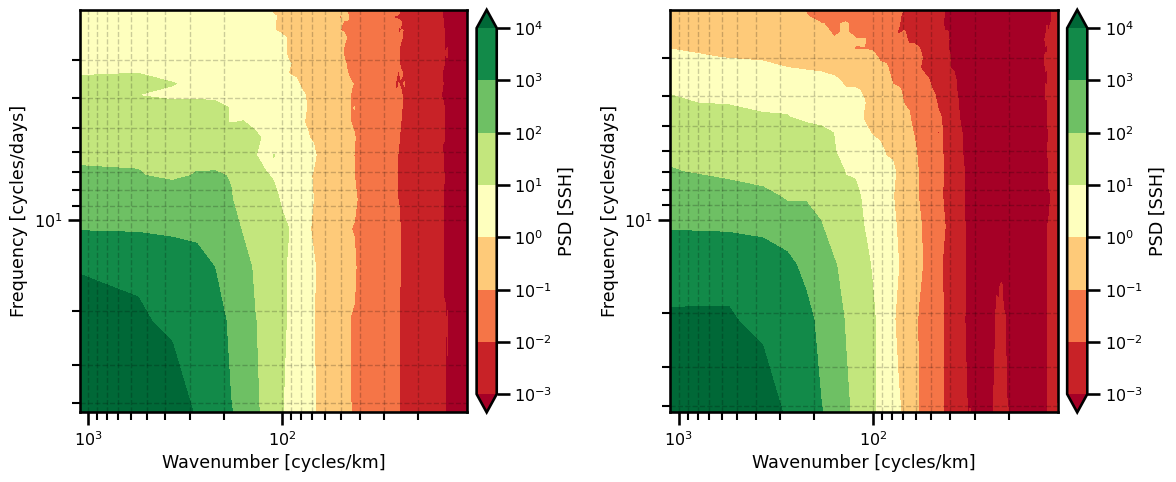

In [132]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax[0])
psd_st_plot.plot_wavenumber(
    da_ref_psd_st.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax[1])
psd_st_plot.plot_wavenumber(
    da_psd_st.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)

plt.tight_layout()
plt.show()

#### Wavelength

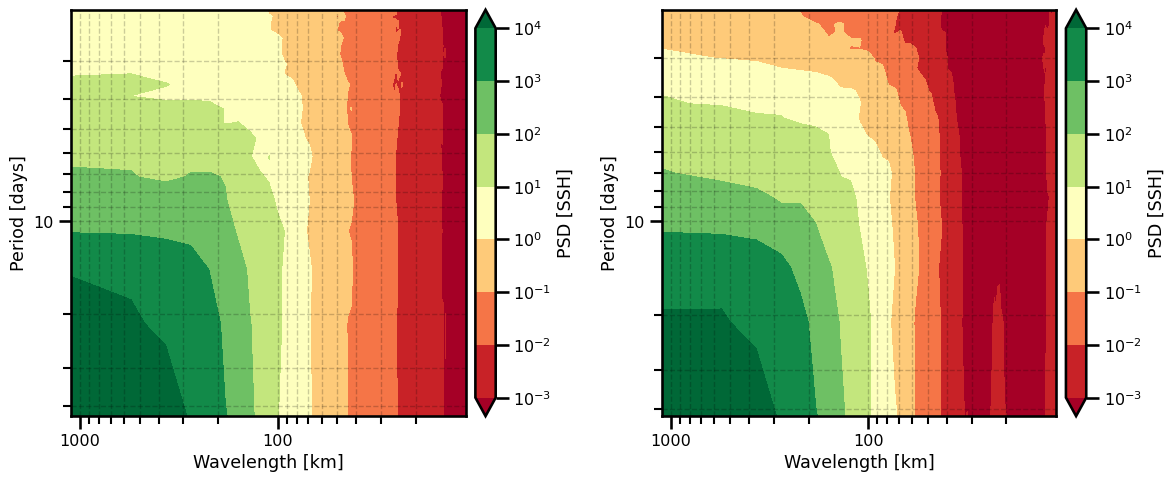

In [133]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax[0])
psd_st_plot.plot_wavelength(
    da_ref_psd_st.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)

psd_st_plot = PlotPSDSpaceTime()
psd_st_plot.init_fig(ax=ax[1])
psd_st_plot.plot_wavelength(
    da_psd_st.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH"
)

plt.tight_layout()
plt.show()

### Space-Time PSD Score

In [134]:
from oceanbench._src.metrics.utils import find_intercept_1D, find_intercept_2D

In [135]:
da_psd_score_st = psdcalc.psd_spacetime_score(
    da=da, da_ref=da_ref, 
    variable="ssh", 
    psd_dims=["time", "lon"],
    avg_dims=["lat"]
)
da_psd_score_st

<xarray.Dataset>
Dimensions:    (freq_time: 20, freq_lon: 99)
Coordinates:
  * freq_time  (freq_time) float64 0.02381 0.04762 0.07143 ... 0.4524 0.4762
  * freq_lon   (freq_lon) float64 9.038e-07 1.808e-06 ... 8.858e-05 8.948e-05
Data variables:
    ssh        (freq_time, freq_lon) float64 0.9915 0.9933 ... -3.242 -3.124

In [136]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker


class PlotPSDSpaceTimeScore:
    def init_fig(self, ax=None, figsize=None):
        if ax is None:
            figsize = (5,4) if figsize is None else figsize
            self.fig, self.ax = plt.subplots(figsize=figsize)
        else:
            self.ax = ax
            self.fig = plt.gcf()
        
    def plot_wavenumber(
        self, 
        da, 
        space_scale: float=1.0,
        space_units: str=None,
        time_units: str=None,
        psd_units: float=None,
        threshhold: float=0.5,
        **kwargs):
        
        if space_units is not None:
            xlabel = f"Wavenumber [cycles/{space_units}]"
        else:
            xlabel = f"Wavenumber"
        if time_units is not None:
            ylabel = f"Frequency [cycles/{time_units}]"
        else:
            ylabel = f"Frequency"

        if psd_units is None:
            cbar_label = "PSD Score"
        else:
            cbar_label = f"PSD Score [{psd_units}]"
        
        
        pts = self.ax.contourf(
            1/(da.freq_lon*space_scale),
            1/da.freq_time, 
            da.transpose("freq_time", "freq_lon"), 
            cmap=kwargs.pop("cmap", "RdBu"), 
            extend=kwargs.pop("extend", "both"),
            levels=np.arange(0, 1.1, 0.1),
            **kwargs
        )

        self.ax.set(
            yscale="log",
            xscale="log",
            xlabel=xlabel,
            ylabel=ylabel,
        )
        # colorbar
        self.cbar = plt.colorbar(
            pts,
            ax=self.ax,
            pad=0.02,
        )
        self.cbar.ax.set_ylabel(cbar_label)

        self.ax.grid(which="both", linestyle="--", linewidth=1, color="black", alpha=0.2)
        
        pts_middle = self.ax.contour(
            1/(da.freq_lon * space_scale),
            1/da.freq_time,
            da.transpose("freq_time", "freq_lon"),
            levels=[threshhold],
            linewidths=2,
            colors="k",
        )
        
        self.cbar.add_lines(pts_middle)
        
        self.ax.invert_xaxis()
        self.ax.invert_yaxis()


    def plot_wavelength(        
        self, 
        da, 
        space_scale: float=1.0,
        space_units: str=None,
        time_units: str=None,
        psd_units: float=None,
        threshhold: float=0.5,
        **kwargs
    ):
    
        if space_units is not None:
            xlabel = f"Wavelength [{space_units}]"
        else:
            xlabel = f"Wavelength"
            
        if time_units is not None:
            ylabel = f"Period Score [{time_units}]"
        else:
            ylabel = f"Period Score"
            
        if psd_units is None:
            cbar_label = "PSD"
        else:
            cbar_label = f"PSD [{psd_units}]"

        self.plot_wavenumber(
            da=da, space_scale=space_scale, 
            space_units=space_units, time_units=time_units,
            psd_units=psd_units, threshhold=threshhold
        )

        self.ax.set(
            xlabel=xlabel, 
            ylabel=ylabel
        )
        self.ax.xaxis.set_major_formatter("{x:.0f}")
        self.ax.yaxis.set_major_formatter("{x:.0f}")

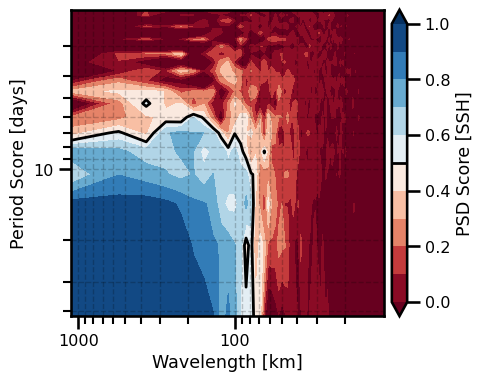

In [137]:

psd_st_plot = PlotPSDSpaceTimeScore()
psd_st_plot.init_fig()
psd_st_plot.plot_wavelength(
    da_psd_score_st.ssh,
    space_scale=1e3, 
    space_units="km", 
    time_units="days",
    psd_units="SSH",
    threshhold=0.5,
)


plt.tight_layout()
plt.show()

In [142]:
lon_rs, time_rs = find_intercept_2D(
        x=1./da_psd_score_st.ssh.freq_lon.values,
        y=1./da_psd_score_st.ssh.freq_time.values, 
        z=da_psd_score_st.ssh.values,
        levels=0.5
    )

In [143]:
print(f"Spatial Resolved Scale: {lon_rs/1e3:.2f} [km]")
print(f"Spatial Resolved Scale: {lon_rs/1e3/111:.2f} [degrees]")
print(f"Time Resolved Scale: {time_rs:.2f} [days]")

Spatial Resolved Scale: 76.19 [km]
Spatial Resolved Scale: 0.69 [degrees]
Time Resolved Scale: 5.83 [days]
